<a href="https://colab.research.google.com/github/elpinchepastel/Hyperspectral-Remote-Sensing-Scenes/blob/master/Indian%20Pines%20Correct%20%2B%20SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Hyperspectral Image Classify**

This project is structured so:

1. Import necessary libraries

2. Download dataset Indian Pines (Correct and gt)

3. Review of dataset structure and loading

4. Visualizing ground truth

5. Visualizing the bands of the Correct

6. Extract pixels and class from the dataset, preparing the data for reduction

7. Classify Indian Pines Correct by support vector machine (SVM)

## **1. Import necessary libraries**

In [1]:
%%time
!pip install spectral
!pip install tqdm

CPU times: user 16.1 ms, sys: 14.3 ms, total: 30.3 ms
Wall time: 4.45 s


In [2]:
import joblib
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import random
import scipy.io
import scipy.io as sio
import seaborn as sns
import spectral

from IPython.display import Image
from matplotlib.legend_handler import HandlerLine2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.io import loadmat
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.svm import SVC
from tqdm import tqdm

sns.axes_style('whitegrid');

# **2. Download dataset Indian Pines (Correct and gt)**

In [3]:
%%time
!wget "http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat"
!wget "http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat"

--2020-10-19 04:04:22--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M) [text/plain]
Saving to: ‘Indian_pines_corrected.mat.8’

Indian_pines_correc 100%[===================>]   5.68M   602KB/s    in 11s     

2020-10-19 04:04:34 (522 KB/s) - ‘Indian_pines_corrected.mat.8’ saved [5953527/5953527]

--2020-10-19 04:04:34--  http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K) [text/plain]
Saving to: ‘Indian_pines_gt.mat.8’

Indian_pines_gt.mat 100%[===================>]   1.10K  --.-KB/s    in 0s      

2020-10-19 04:04:34 (166 MB/s) - ‘Indian_pin

In [4]:
# Verify that the ".mat" type dataset is downloaded locally
!ls

'Classification (PCA + SVM).TIF'
'Confusion Matrix.TIF'
 correct.csv
 correct_model.m
 Dataset.csv
'Indian Pines Correct and SVM.TIF'
'Indian Pines Correct - Band No. 10.TIF'
'Indian Pines Correct - Band No. 12 cmap = gray.TIF'
'Indian Pines Correct - Band No. 12.TIF'
 Indian_pines_corrected.mat
 Indian_pines_corrected.mat.1
 Indian_pines_corrected.mat.2
 Indian_pines_corrected.mat.3
 Indian_pines_corrected.mat.4
 Indian_pines_corrected.mat.5
 Indian_pines_corrected.mat.6
 Indian_pines_corrected.mat.7
 Indian_pines_corrected.mat.8
'Indian Pines Correct - First ten bands.TIF'
'Indian Pines Correct - Teen Band Aleatory.TIF'
'Indian Pines Ground Truth.TIF'
 Indian_pines_gt.mat
 Indian_pines_gt.mat.1
 Indian_pines_gt.mat.2
 Indian_pines_gt.mat.3
 Indian_pines_gt.mat.4
 Indian_pines_gt.mat.5
 Indian_pines_gt.mat.6
 Indian_pines_gt.mat.7
 Indian_pines_gt.mat.8
 KSC.csv
 KSC_MODEL.m
 sample_data
'Samples and number Indian Pines Ground Truth.TIF'


## **3. Review of dataset structure and loading**

In [5]:
# Data types for the dataset
correct = loadmat('Indian_pines_corrected.mat')
gt = loadmat('Indian_pines_gt.mat')
print(type(correct))
print(type(gt))

<class 'dict'>
<class 'dict'>


In [6]:
# The keys of the dictionary
print(f'Dictionary Indian Pines Correct: {correct.keys()}\nDictionary Indian Pines Ground truth: {gt.keys()}')

Dictionary Indian Pines Correct: dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_corrected'])
Dictionary Indian Pines Ground truth: dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_gt'])


In [7]:
# Read the dataset
def dataset(correct, gt):
  dataset_correct = scipy.io.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
  dataset_gt = scipy.io.loadmat('Indian_pines_gt.mat')['indian_pines_gt']
  return dataset_correct, dataset_gt

In [8]:
dataset_correct, dataset_gt = dataset(correct, gt)
print(f'Correct: {dataset_correct.shape}\nGround Truth: {dataset_gt.shape}')

Correct: (145, 145, 200)
Ground Truth: (145, 145)


In [9]:
print(type(dataset_correct))
print(type(dataset_gt))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [10]:
# Number of each category
dict_category = {}
for i in range(dataset_gt.shape[0]):
    for j in range(dataset_gt.shape[1]):
         if dataset_gt[i][j] in [0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]:
            if dataset_gt[i][j] not in dict_category:
                dict_category[dataset_gt[i][j]]=0
            dict_category[dataset_gt[i][j]] +=1
            
sortedDict = sorted(dict_category.items())
print(sortedDict)

[(0, 10776), (1, 46), (2, 1428), (3, 830), (4, 237), (5, 483), (6, 730), (7, 28), (8, 478), (9, 20), (10, 972), (11, 2455), (12, 593), (13, 205), (14, 1265), (15, 386), (16, 93)]


## **4. Visualizing ground truth**

In [11]:
# Colors and names for each category in the dataset
def colors_names():
  gt_color = np.array([
                      [255,   255,    255], #Backgroud
                      [0,     0,      255], #Alfalfa
                      [0,     64,     255], #Corn-notill
                      [0,     128,    255], #Corn-mintill
                      [0,     191,    255], #Corn
                      [0,     255,    255], #Grass-pasture
                      [64,    255,    191], #Grass-trees
                      [128,   255,    128], #Grass-pasture-mowed
                      [191,   255,    64],  #Hay-windrowed
                      [255,   255,    0],   #Oats
                      [255,   191,    0],   #Soybean-notill
                      [255,   128,    0],   #Soybean-mintill
                      [255,   64,     0],   #Soybean-clean
                      [255,   64,     0],   #Wheat
                      [255,   0,      0],   #Woods
                      [191,   0,      0],   #Buildings-Grass-Trees-Drives
                      [128,   0,      0],   #Stone-Steel-Towers
                       ])
  indianpines_class_names = [
                            'Background',
                            'Alfalfa',
                            'Corn-notill',
                            'Corn-min',
                            'Corn',
                            'Grass/pasture',
                            'Grass/trees',
                            'Grass/pasture-mowed',
                            'Hay-windrowed',
                            'Oats',
                            'Soybeans-notill',
                            'Soybeans-min',
                            'Soybean-clean',
                            'Wheat',
                            'Woods',
                            'Bldg-grass-tree-drives',
                            'Stone-steel towers'
                            ]
  gt_color_eventplot = gt_color/255
  return gt_color, gt_color_eventplot, indianpines_class_names

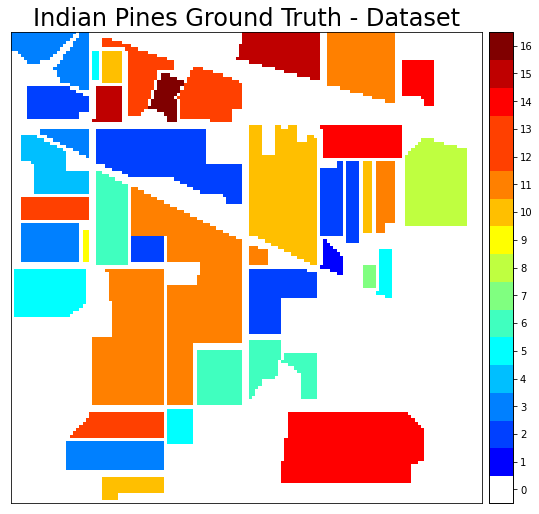

In [12]:
# Display of the "Ground truth" image
gt_color, gt_color_eventplot, indianpines_class_names = colors_names()
ground_truth = spectral.imshow(classes = dataset_gt.astype(int), figsize =(9,9),colors=gt_color, interpolation='nearest')
plt.title('Indian Pines Ground Truth - Dataset', fontsize=24)
plt.xticks([])
plt.yticks([])
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(cax=cax)
plt.colorbar(ticks= range(0,17), cax=cax)
plt.savefig('Indian Pines Ground Truth.TIF')

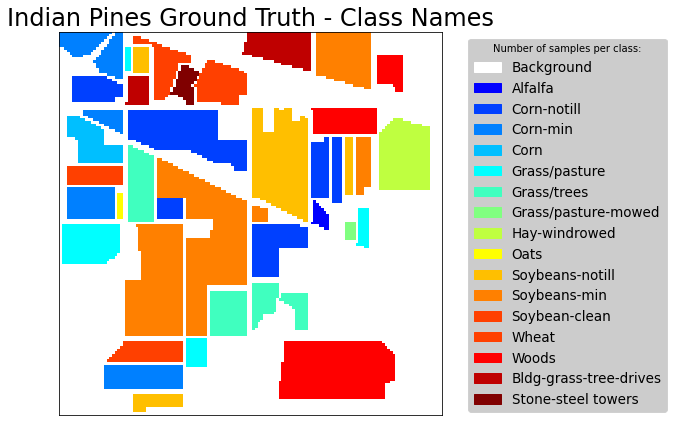

In [13]:
ground_truth = spectral.imshow(classes = dataset_gt.astype(int), figsize =(9,9),colors=gt_color, interpolation='nearest')
plt.title('Indian Pines Ground Truth - Class Names', fontsize=24)
patches = [mpatches.Patch(color=gt_color_eventplot[i], label=indianpines_class_names[i]) for i in range(len(gt_color_eventplot))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1.0), loc='upper left', facecolor='silver', fontsize=13.5, title="Number of samples per class:")
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.savefig('Samples and number Indian Pines Ground Truth.TIF')

## **5. Visualizing the bands of the Hyperspectral Correct**

Enter the band number of the image you want to view (The number to be between 0 and 199): 
10


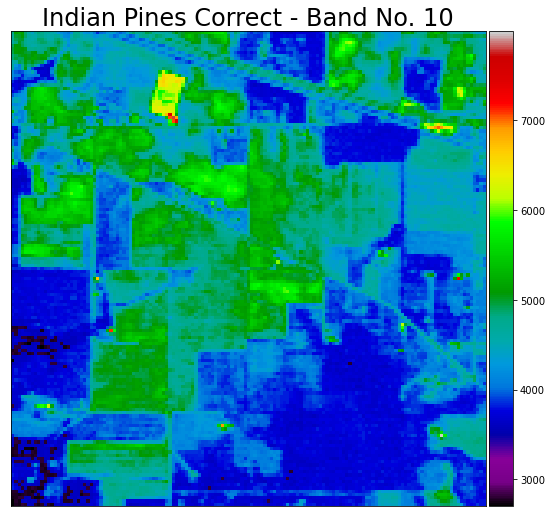

In [14]:
# Display of the "Correct" image on one band

print('Enter the band number of the image you want to view (The number to be between 0 and 199): ')
band = int(input())
one_band = dataset_correct[:, :, band]
plt.figure(figsize=(9, 9))
plt.imshow(one_band, cmap = "nipy_spectral")
plt.title(f'Indian Pines Correct - Band No. {band}', fontsize=24)
plt.xticks([])
plt.yticks([])
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)
plt.savefig(f'Indian Pines Correct - Band No. {band}.TIF')

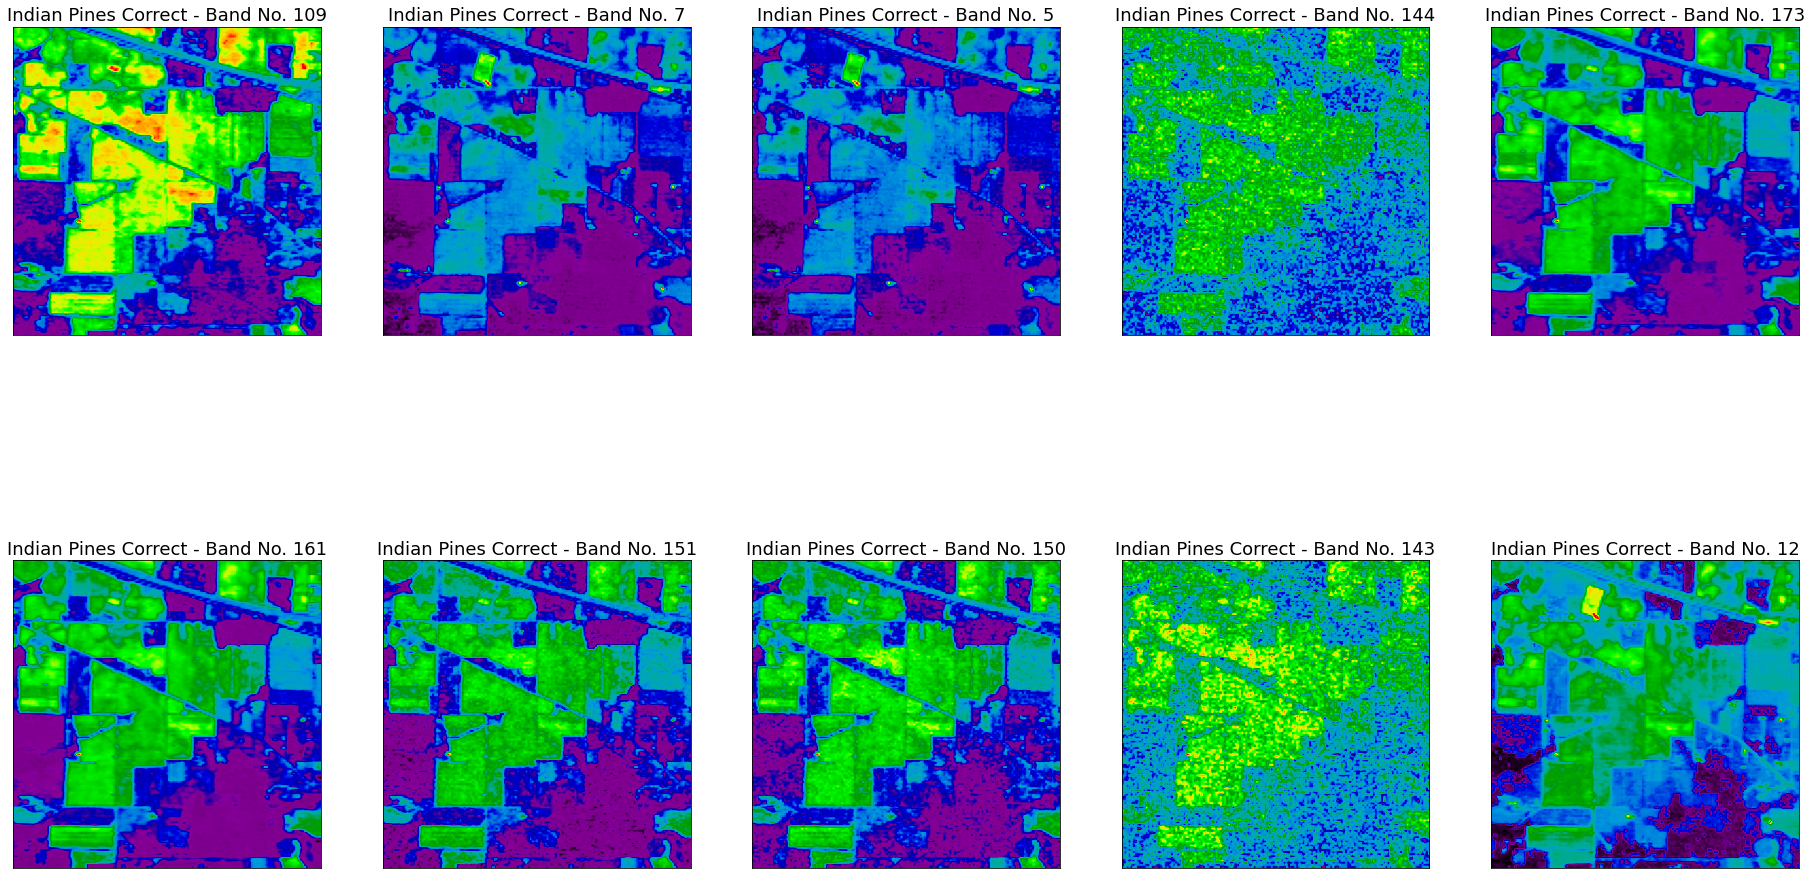

In [15]:
# Display of the "Correct" image on one band random
fig=plt.figure(figsize=(32, 18))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    band_aleatory = random.randrange(199)
    one_band = dataset_correct[:, :, band_aleatory]
    plt.imshow(one_band, cmap = "nipy_spectral")
    plt.title(f'Indian Pines Correct - Band No. {band_aleatory}', fontsize=18)
    plt.xticks([])
    plt.yticks([])
plt.savefig('Indian Pines Correct - Teen Band Aleatory.TIF')

## **6.  Extract pixels and class from the dataset, preparing the data for reduction**

In [16]:
# Refactoring classes
dataset_correct, dataset_gt = dataset(correct, gt)
need_label = np.zeros([dataset_gt.shape[0],dataset_gt.shape[1]])
for i in range(dataset_gt.shape[0]):
    for j in range(dataset_gt.shape[1]):
        if dataset_gt[i][j] != 0:
            need_label[i][j] = dataset_gt[i][j]
        
            
new_datawithlabel_list = []
for i in range(dataset_gt.shape[0]):
    for j in range(dataset_gt.shape[1]):
        if need_label[i][j] != 0:
            c2l = list(dataset_correct[i][j])
            c2l.append(need_label[i][j])
            new_datawithlabel_list.append(c2l)

new_datawithlabel_array = np.array(new_datawithlabel_list)

In [17]:
# Standardize data and store in a CSV file
data_D = preprocessing.StandardScaler().fit_transform(new_datawithlabel_array[:,:-1])
data_L = new_datawithlabel_array[:,-1]
new = np.column_stack((data_D,data_L))
new_ = pd.DataFrame(new)
new_.to_csv('correct.csv',header=False,index=False)

## **7. Classify Indian Pines Correct by support vector machine (SVM)**

In [18]:
# Train the model and store the model
data = pd.read_csv('correct.csv',header=None)
data = data.values
data_D = data[:,:-1]
data_L = data[:,-1]
data_train, data_test, label_train, label_test = train_test_split(data_D,data_L,test_size=0.20, random_state = 11)

clf = SVC(kernel='rbf', degree = 10, gamma='scale', cache_size=1024*7)
clf.fit(data_train,label_train)
pred = clf.predict(data_test)
accuracy = metrics.accuracy_score(label_test, pred)*100
print(accuracy,"%")

joblib.dump(clf, "correct_model.m")

80.92682926829269 %


['correct_model.m']

In [19]:
dataset_correct, dataset_gt = dataset(correct, gt)
input_image = dataset_correct
output_image = dataset_gt

testdata = np.genfromtxt('correct.csv',delimiter=',')
data_test = testdata[:,:-1]
label_test = testdata[:,-1]

clf = joblib.load("correct_model.m")

predict_label = clf.predict(data_test)
accuracy = metrics.accuracy_score(label_test, predict_label)*100

print(accuracy, "%")

81.84213093960386 %


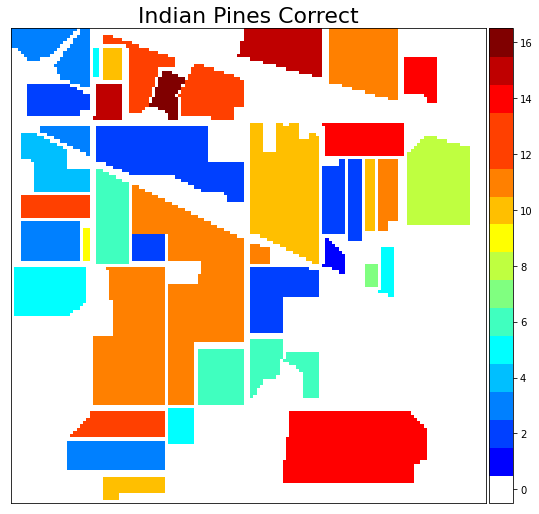

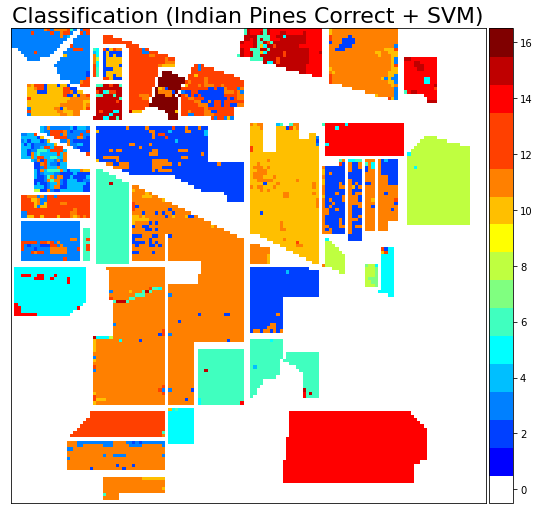

In [20]:
# Displaying the "Indian Pines Correct" and SVM
new_show = np.zeros((output_image.shape[0],output_image.shape[1]))
k = 0
for i in range(output_image.shape[0]):
    for j in range(output_image.shape[1]):
        if output_image[i][j] != 0 :
            new_show[i][j] = predict_label[k]
            k +=1 

gt_color, gt_color_eventplot, indianpines_class_names = colors_names()
dataset_correct, dataset_gt = dataset(correct, gt)
dataset_gt = spectral.imshow(classes = dataset_gt.astype(int), figsize =(9,9),colors=gt_color, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('Indian Pines Correct', fontsize=22)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)

dataset_correct_svm = spectral.imshow(classes = new_show.astype(int), figsize =(9,9),colors=gt_color, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('Classification (Indian Pines Correct + SVM)', fontsize=22)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)

plt.savefig('Indian Pines Correct and SVM.TIF')